<a href="https://colab.research.google.com/github/lim-ye-ji/-/blob/yeji/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from keras.models import Sequential, load_model

import cv2

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/dacon_수화이미지분류/data_train_class/'
data_dir = pathlib.Path(data_dir)

In [5]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

21194


In [6]:
batch_size = 128
img_height = 96
img_width = 96

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split = 0.25,
  subset = "training",
  seed = 123,
  image_size = [img_height, img_width],
  batch_size = batch_size)

Found 21194 files belonging to 11 classes.
Using 15896 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split = 0.25,
  subset = "validation",
  seed = 123,
  image_size = [img_height, img_width],
  batch_size = batch_size)

Found 21194 files belonging to 11 classes.
Using 5298 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)
class_count = len(class_names)
print(class_count)

['1', '10-1', '10-2', '2', '3', '4', '5', '6', '7', '8', '9']
11


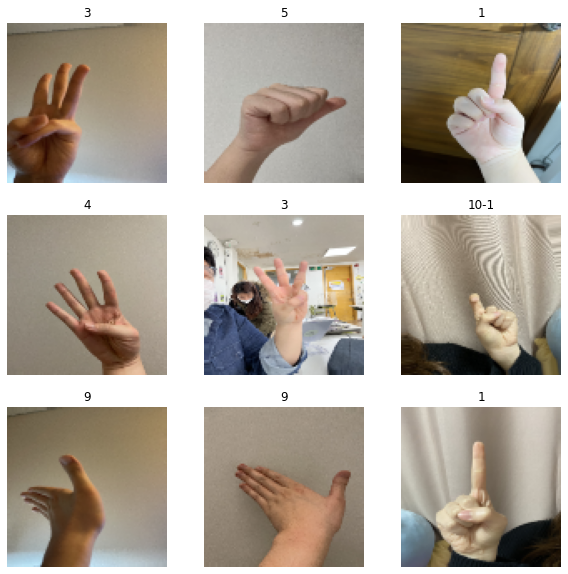

In [ ]:
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
'''
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))
'''

0.016121993 0.8723312


In [10]:
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width, 3)),
    
    layers.Conv2D(16, (5, 5), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(32, (5, 5), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    keras.layers.Conv2D(64, (5, 5), activation = "relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(128, (3, 3), activation = "relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    
    layers.Dense(256, activation = 'relu'),
    
    layers.Flatten(),
    
    layers.Dense(128, activation = "relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation = "relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation = "relu"),
    layers.Dropout(0.2),
    layers.Dense(16, activation = "relu"),
    layers.Dropout(0.2),
    
    layers.Dense(class_count, activation = 'softmax')
])

In [11]:
model.compile(#optimizer = 'adam',
              optimizer = keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 92, 92, 16)        1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 46, 46, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 32)       0         
 2D)                                                    

In [13]:
EPOCHS = 100
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

In [14]:
history = model.fit(train_ds,
                    validation_data = val_ds, 
                    epochs = EPOCHS,
                    callbacks = [early_stop])

Epoch 1/100
125/125 [==============================] - 2815s 21s/step - loss: 2.3985 - accuracy: 0.0874 - val_loss: 2.3980 - val_accuracy: 0.0804
Epoch 2/100
125/125 [==============================] - 25s 191ms/step - loss: 2.3979 - accuracy: 0.0934 - val_loss: 2.3979 - val_accuracy: 0.0948
Epoch 3/100
125/125 [==============================] - 25s 193ms/step - loss: 2.3978 - accuracy: 0.0916 - val_loss: 2.3979 - val_accuracy: 0.0948
Epoch 4/100
125/125 [==============================] - 25s 190ms/step - loss: 2.3978 - accuracy: 0.0926 - val_loss: 2.3979 - val_accuracy: 0.0948
Epoch 5/100
125/125 [==============================] - 25s 192ms/step - loss: 2.3976 - accuracy: 0.0964 - val_loss: 2.3981 - val_accuracy: 0.0948
Epoch 6/100
125/125 [==============================] - 25s 192ms/step - loss: 2.3979 - accuracy: 0.0921 - val_loss: 2.3980 - val_accuracy: 0.0936
Epoch 7/100
125/125 [==============================] - 25s 191ms/step - loss: 2.3982 - accuracy: 0.0912 - val_loss: 2.3979 -

In [15]:
model.save('/content/drive/MyDrive/Colab Notebooks/dacon_수화이미지분류/model_0518v16.h5')

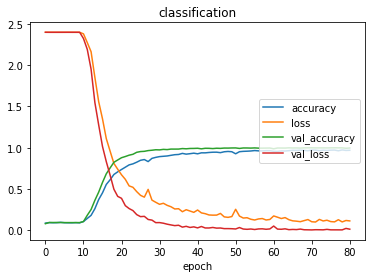

In [16]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('classification')
plt.xlabel('epoch')
plt.legend(loc = 'center right')
plt.show()

# 테스트

In [17]:
import pandas as pd

In [18]:
basePath = '/content/drive/MyDrive/Colab Notebooks/dacon_수화이미지분류/'

In [19]:
test_dir = basePath + "user_data/test"
test_dir = pathlib.Path(test_dir)

In [20]:
batch_size = 128
img_height = 96
img_width = 96

In [21]:
image_count = len(list(test_dir.glob('*/*.png')))
print(image_count)

0


In [22]:
class_names = os.listdir(basePath + "data_train_class")
class_names.sort()
class_names

['1', '10-1', '10-2', '2', '3', '4', '5', '6', '7', '8', '9']

In [23]:
imageList = list(test_dir.glob('*/*.png'))
# print(imageList)

In [24]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels = None,
    seed = 123,
    shuffle = False,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 215 files belonging to 1 classes.


In [25]:
test_df = pd.read_csv(basePath + 'user_data/test.csv')
test_df.head()

,file_name
0,001.png
1,002.png
2,003.png
3,004.png
4,005.png


In [26]:
model = load_model(basePath + 'model_0518v16.h5')

In [27]:
test_list = model.predict(test_ds)

In [28]:
accuracy_list = []

for i in range(len(test_list)):
    id = np.argmax(test_list[i])
    accuracy_list.append(id)

In [29]:
accuracy_list2 = accuracy_list.copy()

accuracy_list3 = []
for i in range(len(accuracy_list2)):
  accuracy_list3.append(class_names[accuracy_list[i]])

In [30]:
accuracy_df = pd.DataFrame(accuracy_list3, columns = ['label']) # 데이터프레임으로 변환
class_df = pd.concat([test_df, accuracy_df], axis = 1)

In [31]:
class_df.head(10)

,file_name,label
0,001.png,1
1,002.png,1
2,003.png,1
3,004.png,6
4,005.png,8
5,006.png,10-1
6,007.png,10-1
7,008.png,2
8,009.png,4
9,010.png,4


In [32]:
class_df.reset_index(drop = True)

,file_name,label
0,001.png,1
1,002.png,1
2,003.png,1
3,004.png,6
4,005.png,8
...,...,...
210,211.png,5
211,212.png,8
212,213.png,3
213,214.png,6


In [33]:
class_df.to_csv(basePath + "test_220518_16.csv", index = False, mode = 'w')